## Brain MRI Tumor Detection - Imperative CNN with PyTorch

##### Chindea Cosmin, Codreanu Alexandru, Boanc Ionut

This project implements a CNN for detecting brain tumors from MRI scans. The dataset contains MRI images classified into two categories: tumor present and no tumor. This is a binary classification problem focused on medical image analysis. The project is about comparing iterative PyTorch vs functional PyTorch vs Elixir's Axon.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import psutil
import os
import gc

# Disable background processes for consistent timing
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# Memory tracking functions
def get_memory_usage():
    """Get current CPU memory usage in MB"""
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1024 / 1024

def get_gpu_memory_peak():
    """Get peak GPU memory usage in MB"""
    if torch.cuda.is_available():
        return torch.cuda.max_memory_allocated() / 1024 / 1024
    return 0

# Check CUDA availability
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name()}")
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using: {device}")

initial_cpu_memory = get_memory_usage()
initial_gpu_memory = get_gpu_memory_peak()
print(f"\nInitial CPU Memory: {initial_cpu_memory:.2f} MB")
print(f"Initial GPU Memory: {initial_gpu_memory:.2f} MB")


CUDA device: NVIDIA GeForce RTX 4050 Laptop GPU
Using: cuda

Initial CPU Memory: 611.57 MB
Initial GPU Memory: 0.00 MB


In [2]:
# Dataset Loading
from pathlib import Path
import torch.utils.data as data
from sklearn.model_selection import train_test_split

data_dir = Path("./data/brain_tumor_dataset")
if not data_dir.exists():
    raise FileNotFoundError(f"Dataset not found at {data_dir}")

class_names = ['No Tumor', 'Tumor']

train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    
    # Enhanced geometric transformations
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(degrees=20),
    transforms.RandomAffine(
        degrees=0,
        translate=(0.15, 0.15),
        scale=(0.85, 1.15),
        shear=10
    ),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.3),
    
    # MRI-specific augmentations
    transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),
    transforms.ColorJitter(
        brightness=0.3,
        contrast=0.3,
        saturation=0.2,
        hue=0.1
    ),
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.3),
    
    transforms.ToTensor(),
    # Add random noise for MRI realism
    transforms.Lambda(lambda x: x + torch.randn_like(x) * 0.02),
    transforms.Normalize(mean=[0.248, 0.248, 0.249], std=[0.211, 0.211, 0.211]),
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.248, 0.248, 0.249], std=[0.211, 0.211, 0.211])
])

# Load base dataset to extract labels for stratified split
base_dataset = torchvision.datasets.ImageFolder(root=data_dir)
labels = [label for _, label in base_dataset]
indices = list(range(len(base_dataset)))

# Stratified split (70% train, 30% val) due to class imbalance
train_indices, val_indices = train_test_split(
    indices, 
    test_size=0.3, 
    stratify=labels,
    random_state=42
)

# Create datasets with appropriate transforms
train_dataset_full = torchvision.datasets.ImageFolder(root=data_dir, transform=train_transform)
val_dataset_full = torchvision.datasets.ImageFolder(root=data_dir, transform=test_transform)

# Apply indices to create subsets
train_dataset = data.Subset(train_dataset_full, train_indices)
val_dataset = data.Subset(val_dataset_full, val_indices)

# Check class distribution in both sets
train_targets = [train_dataset_full.targets[i] for i in train_indices]
val_targets = [val_dataset_full.targets[i] for i in val_indices]

print(f"\nTraining set class distribution:")
print(f"  {class_names[0]}: {train_targets.count(0)} samples ({100*train_targets.count(0)/len(train_targets):.1f}%)")
print(f"  {class_names[1]}: {train_targets.count(1)} samples ({100*train_targets.count(1)/len(train_targets):.1f}%)")

print(f"\nValidation set class distribution:")
print(f"  {class_names[0]}: {val_targets.count(0)} samples ({100*val_targets.count(0)/len(val_targets):.1f}%)")
print(f"  {class_names[1]}: {val_targets.count(1)} samples ({100*val_targets.count(1)/len(val_targets):.1f}%)")

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
num_classes = len(class_names)


Training set class distribution:
  No Tumor: 69 samples (39.0%)
  Tumor: 108 samples (61.0%)

Validation set class distribution:
  No Tumor: 29 samples (38.2%)
  Tumor: 47 samples (61.8%)


In [3]:
class BrainTumorCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(BrainTumorCNN, self).__init__()
        
        # Convolutional layers - reduced final channels to 128
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)  # Changed from 256 to 128
        
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout_conv = nn.Dropout(0.3)  # Dropout after conv layers
        self.dropout_fc = nn.Dropout(0.5)    # Dropout after fc layers
        
        # Better fully connected layers with gradual reduction
        self.fc1 = nn.Linear(128 * 8 * 8, 512)  # 8192 -> 512
        self.fc2 = nn.Linear(512, 128)          # 512 -> 128
        self.fc3 = nn.Linear(128, num_classes)  # 128 -> 2
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout_conv(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.dropout_conv(x)
        
        x = x.view(x.size(0), -1)
        x = self.dropout_fc(F.relu(self.fc1(x)))
        x = self.dropout_fc(F.relu(self.fc2(x)))
        x = self.fc3(x)
        
        return x

model = BrainTumorCNN(num_classes=num_classes).to(device)
print(f"Model created: {sum(p.numel() for p in model.parameters()):,} parameters")

Model created: 4,501,570 parameters


In [4]:
# Training function with validation and model checkpointing
def train_model(model, num_epochs=150):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=20)
    min_lr = 1e-5
    
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    epoch_times = []
    
    # Model checkpointing variables
    best_val_loss = float('inf')
    best_model_state = None
    best_epoch = 0
    
    # Clear GPU cache and reset memory stats
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
    
    # Force garbage collection
    gc.collect()
    
    # Memory tracking baseline (before reset)
    baseline_cpu_memory = get_memory_usage()
    if torch.cuda.is_available():
        baseline_gpu_memory = torch.cuda.memory_allocated() / 1024 / 1024  # Current allocation
        torch.cuda.reset_peak_memory_stats()  # Reset AFTER capturing baseline
    else:
        baseline_gpu_memory = 0.0
    
    total_start_time = time.time()
    max_gpu_memory = baseline_gpu_memory
    
    for epoch in range(num_epochs):
        # Synchronize before epoch timing
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        epoch_start_time = time.time()
        
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
        
        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = 100. * correct / total
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                
                val_running_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                val_total += target.size(0)
                val_correct += (predicted == target).sum().item()
        
        epoch_val_loss = val_running_loss / len(val_loader)
        epoch_val_acc = 100. * val_correct / val_total
        
        # Synchronize before timing end
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        
        # Track time and memory
        epoch_time = time.time() - epoch_start_time
        epoch_times.append(epoch_time)
        
        current_cpu_memory = get_memory_usage()
        if torch.cuda.is_available():
            current_gpu_peak = torch.cuda.max_memory_allocated() / 1024 / 1024
            max_gpu_memory = max(max_gpu_memory, current_gpu_peak)
        else:
            current_gpu_peak = 0.0
        
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)
        
        # Learning rate scheduling
        old_lr = optimizer.param_groups[0]['lr']
        scheduler.step(epoch_val_loss)
        new_lr = optimizer.param_groups[0]['lr']
        
        # Enforce minimum learning rate
        if new_lr < min_lr:
            for param_group in optimizer.param_groups:
                param_group['lr'] = min_lr
            new_lr = min_lr
        
        # Check if this is the best model (based on validation loss - lower is better)
        marker = ""
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_epoch = epoch
            best_model_state = model.state_dict().copy()
            marker = " <- BEST"
        
        # Display progress every epoch
        if (epoch + 1) % 1 == 0:
            lr_change = f" [LR: {old_lr:.6f} -> {new_lr:.6f}]" if old_lr != new_lr else ""
            print(f"Epoch {epoch+1}/{num_epochs}{lr_change}")
            print(f"  Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.2f}%")
            print(f"  Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.2f}%{marker}")
            print(f"  Time: {epoch_time:.2f}s | CPU: {current_cpu_memory:.0f}MB | GPU: {current_gpu_peak:.0f}MB")
    
    # Final synchronization
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    
    # Calculate total training time
    total_time = time.time() - total_start_time
    avg_epoch_time = sum(epoch_times) / len(epoch_times)
    
    # Final memory stats
    final_cpu_memory = get_memory_usage() - baseline_cpu_memory
    final_gpu_memory = max_gpu_memory - baseline_gpu_memory  # Peak during training minus baseline
    
    # Restore best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"\n{'='*70}")
        print(f"Restoring Best Model from Epoch {best_epoch+1}")
        print(f"{'='*70}")
        print(f"  CPU Memory Delta: {final_cpu_memory:.2f} MB")
        print(f"  Peak GPU Memory: {final_gpu_memory:.2f} MB")
        print(f"  Best Validation Loss: {best_val_loss:.4f}")
        print(f"  Validation Accuracy at Best Epoch: {val_accuracies[best_epoch]:.2f}%")
        print(f"  Training Loss at Best Epoch: {train_losses[best_epoch]:.4f}")
        print(f"  Training Accuracy at Best Epoch: {train_accuracies[best_epoch]:.2f}%")
        print(f"{'='*70}")
        
        # Save model with performance metrics
        model_save_path = 'best_imperative_model.pth'
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': best_epoch,
            'train_losses': train_losses,
            'train_accs': train_accuracies,
            'val_losses': val_losses,
            'val_accs': val_accuracies,
            'total_time': total_time,
            'avg_epoch_time': avg_epoch_time,
            'max_cpu_memory': final_cpu_memory,
            'max_gpu_memory': final_gpu_memory,
        }, model_save_path)
        print(f"  Model saved to: {model_save_path}\n")
    
    return {
        'train_losses': train_losses,
        'train_accs': train_accuracies,
        'val_losses': val_losses,
        'val_accs': val_accuracies,
        'best_epoch': best_epoch,
        'total_time': total_time,
        'avg_epoch_time': avg_epoch_time,
        'epoch_times': epoch_times,
        'max_cpu_memory': final_cpu_memory,
        'max_gpu_memory': final_gpu_memory,
    }


In [5]:
# Evaluation function
def evaluate_model(model):
    from sklearn.metrics import roc_auc_score
    
    # Synchronize before timing
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    
    eval_start_time = time.time()
    
    model.eval()
    criterion = nn.CrossEntropyLoss()
    val_loss = 0
    correct = 0
    total = 0
    
    class_correct = [0, 0]
    class_total = [0, 0]
    
    all_predictions = []
    all_targets = []
    all_probabilities = []
    
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            val_loss += criterion(output, target).item()
            probabilities = F.softmax(output, dim=1)
            _, predicted = torch.max(output, 1)
            
            total += target.size(0)
            correct += (predicted == target).sum().item()
            
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
            
            for i in range(target.size(0)):
                label = target[i].item()
                class_correct[label] += (predicted[i] == target[i]).item()
                class_total[label] += 1
    
    # Synchronize before timing end
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    
    eval_time = time.time() - eval_start_time
    
    accuracy = 100 * correct / total
    val_loss = val_loss / len(val_loader)
    
    tumor_probs = [p[1] for p in all_probabilities]
    auc_score = roc_auc_score(all_targets, tumor_probs)
    
    print(f"\nValidation Results:")
    print(f"  Accuracy: {accuracy:.2f}%")
    print(f"  Loss: {val_loss:.4f}")
    print(f"  AUC: {auc_score:.3f}")
    print(f"  Evaluation Time: {eval_time:.2f}s")
    print(f"  Probability range: [{min(tumor_probs):.4f}, {max(tumor_probs):.4f}]")
    print(f"\nPer-class accuracy:")
    for i in range(2):
        if class_total[i] > 0:
            class_acc = 100 * class_correct[i] / class_total[i]
            print(f"  {class_names[i]}: {class_acc:.1f}% ({class_total[i]} samples)")
    
    return val_loss, accuracy, class_correct, class_total, auc_score, eval_time


In [6]:
# Train and evaluate with longer training
num_epochs = 150

history = train_model(model, num_epochs=num_epochs)
val_loss, val_acc, class_correct, class_total, auc_score, eval_time = evaluate_model(model)

Epoch 1/150
  Train Loss: 0.6950 | Train Acc: 56.50%
  Val Loss: 0.6684 | Val Acc: 61.84% <- BEST
  Time: 1.35s | CPU: 1278MB | GPU: 323MB


Epoch 2/150
  Train Loss: 0.6663 | Train Acc: 61.58%
  Val Loss: 0.6330 | Val Acc: 61.84% <- BEST
  Time: 1.06s | CPU: 1281MB | GPU: 323MB


Epoch 3/150
  Train Loss: 0.6689 | Train Acc: 61.58%
  Val Loss: 0.6637 | Val Acc: 61.84%
  Time: 1.03s | CPU: 1281MB | GPU: 323MB


Epoch 4/150
  Train Loss: 0.6715 | Train Acc: 64.41%
  Val Loss: 0.6574 | Val Acc: 61.84%
  Time: 1.05s | CPU: 1281MB | GPU: 323MB


Epoch 5/150
  Train Loss: 0.6617 | Train Acc: 61.02%
  Val Loss: 0.6180 | Val Acc: 61.84% <- BEST
  Time: 1.05s | CPU: 1281MB | GPU: 323MB


Epoch 6/150
  Train Loss: 0.6576 | Train Acc: 61.02%
  Val Loss: 0.6234 | Val Acc: 61.84%
  Time: 1.08s | CPU: 1281MB | GPU: 323MB


Epoch 7/150
  Train Loss: 0.6359 | Train Acc: 61.02%
  Val Loss: 0.6191 | Val Acc: 61.84%
  Time: 1.13s | CPU: 1281MB | GPU: 323MB


Epoch 8/150
  Train Loss: 0.6609 | Train Acc: 61.02%
  Val Loss: 0.6273 | Val Acc: 61.84%
  Time: 1.22s | CPU: 1281MB | GPU: 323MB


Epoch 9/150
  Train Loss: 0.6398 | Train Acc: 61.02%
  Val Loss: 0.6116 | Val Acc: 61.84% <- BEST
  Time: 1.21s | CPU: 1281MB | GPU: 323MB


Epoch 10/150
  Train Loss: 0.6564 | Train Acc: 61.02%
  Val Loss: 0.5905 | Val Acc: 61.84% <- BEST
  Time: 1.28s | CPU: 1281MB | GPU: 323MB


Epoch 11/150
  Train Loss: 0.6408 | Train Acc: 61.58%
  Val Loss: 0.6269 | Val Acc: 61.84%
  Time: 1.28s | CPU: 1281MB | GPU: 323MB


Epoch 12/150
  Train Loss: 0.6247 | Train Acc: 61.58%
  Val Loss: 0.5821 | Val Acc: 61.84% <- BEST
  Time: 1.37s | CPU: 1282MB | GPU: 323MB


Epoch 13/150
  Train Loss: 0.6313 | Train Acc: 61.58%
  Val Loss: 0.5982 | Val Acc: 64.47%
  Time: 1.41s | CPU: 1282MB | GPU: 323MB


Epoch 14/150
  Train Loss: 0.6171 | Train Acc: 62.71%
  Val Loss: 0.5776 | Val Acc: 64.47% <- BEST
  Time: 1.44s | CPU: 1282MB | GPU: 323MB


Epoch 15/150
  Train Loss: 0.6075 | Train Acc: 63.28%
  Val Loss: 0.5708 | Val Acc: 71.05% <- BEST
  Time: 1.44s | CPU: 1282MB | GPU: 323MB


Epoch 16/150
  Train Loss: 0.6201 | Train Acc: 64.97%
  Val Loss: 0.5762 | Val Acc: 77.63%
  Time: 1.37s | CPU: 1282MB | GPU: 323MB


Epoch 17/150
  Train Loss: 0.6216 | Train Acc: 68.36%
  Val Loss: 0.5755 | Val Acc: 76.32%
  Time: 1.38s | CPU: 1282MB | GPU: 323MB


Epoch 18/150
  Train Loss: 0.6203 | Train Acc: 67.80%
  Val Loss: 0.5668 | Val Acc: 75.00% <- BEST
  Time: 1.40s | CPU: 1282MB | GPU: 323MB


Epoch 19/150
  Train Loss: 0.5886 | Train Acc: 69.49%
  Val Loss: 0.5274 | Val Acc: 72.37% <- BEST
  Time: 1.39s | CPU: 1282MB | GPU: 323MB


Epoch 20/150
  Train Loss: 0.6165 | Train Acc: 69.49%
  Val Loss: 0.5527 | Val Acc: 68.42%
  Time: 1.43s | CPU: 1282MB | GPU: 323MB


Epoch 21/150
  Train Loss: 0.6130 | Train Acc: 69.49%
  Val Loss: 0.5551 | Val Acc: 75.00%
  Time: 1.41s | CPU: 1283MB | GPU: 323MB


Epoch 22/150
  Train Loss: 0.5721 | Train Acc: 72.88%
  Val Loss: 0.5112 | Val Acc: 72.37% <- BEST
  Time: 1.07s | CPU: 1283MB | GPU: 323MB


Epoch 23/150
  Train Loss: 0.6205 | Train Acc: 69.49%
  Val Loss: 0.4864 | Val Acc: 80.26% <- BEST
  Time: 1.06s | CPU: 1273MB | GPU: 323MB


Epoch 24/150
  Train Loss: 0.5764 | Train Acc: 66.10%
  Val Loss: 0.6006 | Val Acc: 71.05%
  Time: 1.09s | CPU: 1282MB | GPU: 323MB


Epoch 25/150
  Train Loss: 0.6535 | Train Acc: 62.15%
  Val Loss: 0.5917 | Val Acc: 81.58%
  Time: 1.13s | CPU: 1282MB | GPU: 323MB


Epoch 26/150
  Train Loss: 0.5635 | Train Acc: 66.67%
  Val Loss: 0.5113 | Val Acc: 75.00%
  Time: 1.24s | CPU: 1282MB | GPU: 323MB


Epoch 27/150
  Train Loss: 0.5578 | Train Acc: 72.32%
  Val Loss: 0.5141 | Val Acc: 81.58%
  Time: 1.30s | CPU: 1282MB | GPU: 323MB


Epoch 28/150
  Train Loss: 0.5835 | Train Acc: 68.93%
  Val Loss: 0.5028 | Val Acc: 82.89%
  Time: 1.38s | CPU: 1282MB | GPU: 323MB


Epoch 29/150
  Train Loss: 0.6229 | Train Acc: 70.62%
  Val Loss: 0.4601 | Val Acc: 84.21% <- BEST
  Time: 1.42s | CPU: 1282MB | GPU: 323MB


Epoch 30/150
  Train Loss: 0.5897 | Train Acc: 70.06%
  Val Loss: 0.4810 | Val Acc: 76.32%
  Time: 1.42s | CPU: 1283MB | GPU: 323MB


Epoch 31/150
  Train Loss: 0.5712 | Train Acc: 70.62%
  Val Loss: 0.4816 | Val Acc: 75.00%
  Time: 1.43s | CPU: 1283MB | GPU: 323MB


Epoch 32/150
  Train Loss: 0.5604 | Train Acc: 72.88%
  Val Loss: 0.4570 | Val Acc: 80.26% <- BEST
  Time: 1.43s | CPU: 1283MB | GPU: 323MB


Epoch 33/150
  Train Loss: 0.5292 | Train Acc: 75.14%
  Val Loss: 0.4287 | Val Acc: 80.26% <- BEST
  Time: 1.45s | CPU: 1283MB | GPU: 323MB


Epoch 34/150
  Train Loss: 0.5647 | Train Acc: 75.71%
  Val Loss: 0.4306 | Val Acc: 77.63%
  Time: 1.31s | CPU: 1283MB | GPU: 323MB


Epoch 35/150
  Train Loss: 0.5216 | Train Acc: 74.01%
  Val Loss: 0.4311 | Val Acc: 81.58%
  Time: 1.33s | CPU: 1283MB | GPU: 323MB


Epoch 36/150
  Train Loss: 0.5465 | Train Acc: 77.97%
  Val Loss: 0.4754 | Val Acc: 77.63%
  Time: 1.31s | CPU: 1283MB | GPU: 323MB


Epoch 37/150
  Train Loss: 0.5546 | Train Acc: 73.45%
  Val Loss: 0.4388 | Val Acc: 82.89%
  Time: 1.31s | CPU: 1283MB | GPU: 323MB


Epoch 38/150
  Train Loss: 0.5305 | Train Acc: 77.40%
  Val Loss: 0.4046 | Val Acc: 81.58% <- BEST
  Time: 1.40s | CPU: 1283MB | GPU: 323MB


Epoch 39/150
  Train Loss: 0.5426 | Train Acc: 75.71%
  Val Loss: 0.4401 | Val Acc: 80.26%
  Time: 1.44s | CPU: 1283MB | GPU: 323MB


Epoch 40/150
  Train Loss: 0.5700 | Train Acc: 74.01%
  Val Loss: 0.4305 | Val Acc: 84.21%
  Time: 1.42s | CPU: 1283MB | GPU: 323MB


Epoch 41/150
  Train Loss: 0.5122 | Train Acc: 72.32%
  Val Loss: 0.4400 | Val Acc: 80.26%
  Time: 1.47s | CPU: 1283MB | GPU: 323MB


Epoch 42/150
  Train Loss: 0.5474 | Train Acc: 76.27%
  Val Loss: 0.4837 | Val Acc: 75.00%
  Time: 1.31s | CPU: 1283MB | GPU: 323MB


Epoch 43/150
  Train Loss: 0.5177 | Train Acc: 77.97%
  Val Loss: 0.3841 | Val Acc: 82.89% <- BEST
  Time: 1.37s | CPU: 1283MB | GPU: 323MB


Epoch 44/150
  Train Loss: 0.5056 | Train Acc: 76.84%
  Val Loss: 0.3872 | Val Acc: 81.58%
  Time: 1.42s | CPU: 1283MB | GPU: 323MB


Epoch 45/150
  Train Loss: 0.4955 | Train Acc: 77.40%
  Val Loss: 0.3743 | Val Acc: 86.84% <- BEST
  Time: 1.42s | CPU: 1283MB | GPU: 323MB


Epoch 46/150
  Train Loss: 0.4779 | Train Acc: 78.53%
  Val Loss: 0.4286 | Val Acc: 82.89%
  Time: 1.38s | CPU: 1283MB | GPU: 323MB


Epoch 47/150
  Train Loss: 0.4938 | Train Acc: 79.66%
  Val Loss: 0.3512 | Val Acc: 84.21% <- BEST
  Time: 1.45s | CPU: 1283MB | GPU: 323MB


Epoch 48/150
  Train Loss: 0.6140 | Train Acc: 72.88%
  Val Loss: 0.5769 | Val Acc: 71.05%
  Time: 1.42s | CPU: 1283MB | GPU: 323MB


Epoch 49/150
  Train Loss: 0.5071 | Train Acc: 77.40%
  Val Loss: 0.4264 | Val Acc: 78.95%
  Time: 1.45s | CPU: 1283MB | GPU: 323MB


Epoch 50/150
  Train Loss: 0.5257 | Train Acc: 74.01%
  Val Loss: 0.4652 | Val Acc: 82.89%
  Time: 1.34s | CPU: 1284MB | GPU: 323MB


Epoch 51/150
  Train Loss: 0.4362 | Train Acc: 80.23%
  Val Loss: 0.4114 | Val Acc: 82.89%
  Time: 1.31s | CPU: 1284MB | GPU: 323MB


Epoch 52/150
  Train Loss: 0.4898 | Train Acc: 76.84%
  Val Loss: 0.4300 | Val Acc: 77.63%
  Time: 1.40s | CPU: 1284MB | GPU: 323MB


Epoch 53/150
  Train Loss: 0.4897 | Train Acc: 75.71%
  Val Loss: 0.4444 | Val Acc: 75.00%
  Time: 1.44s | CPU: 1284MB | GPU: 323MB


Epoch 54/150
  Train Loss: 0.4381 | Train Acc: 79.10%
  Val Loss: 0.3891 | Val Acc: 77.63%
  Time: 1.44s | CPU: 1284MB | GPU: 323MB


Epoch 55/150
  Train Loss: 0.4871 | Train Acc: 78.53%
  Val Loss: 0.3590 | Val Acc: 82.89%
  Time: 1.41s | CPU: 1284MB | GPU: 323MB


Epoch 56/150
  Train Loss: 0.4439 | Train Acc: 83.05%
  Val Loss: 0.3613 | Val Acc: 85.53%
  Time: 1.40s | CPU: 1284MB | GPU: 323MB


Epoch 57/150
  Train Loss: 0.4394 | Train Acc: 79.10%
  Val Loss: 0.3423 | Val Acc: 85.53% <- BEST
  Time: 1.30s | CPU: 1284MB | GPU: 323MB


Epoch 58/150
  Train Loss: 0.4598 | Train Acc: 78.53%
  Val Loss: 0.3240 | Val Acc: 84.21% <- BEST
  Time: 1.36s | CPU: 1284MB | GPU: 323MB


Epoch 59/150
  Train Loss: 0.3839 | Train Acc: 84.75%
  Val Loss: 0.3081 | Val Acc: 84.21% <- BEST
  Time: 1.32s | CPU: 1284MB | GPU: 323MB


Epoch 60/150
  Train Loss: 0.4422 | Train Acc: 81.92%
  Val Loss: 0.6523 | Val Acc: 68.42%
  Time: 1.38s | CPU: 1284MB | GPU: 323MB


Epoch 61/150
  Train Loss: 0.5602 | Train Acc: 72.88%
  Val Loss: 0.4218 | Val Acc: 78.95%
  Time: 1.38s | CPU: 1284MB | GPU: 323MB


Epoch 62/150
  Train Loss: 0.4862 | Train Acc: 75.14%
  Val Loss: 0.3921 | Val Acc: 84.21%
  Time: 1.43s | CPU: 1284MB | GPU: 323MB


Epoch 63/150
  Train Loss: 0.4588 | Train Acc: 80.79%
  Val Loss: 0.3707 | Val Acc: 85.53%
  Time: 1.44s | CPU: 1284MB | GPU: 323MB


Epoch 64/150
  Train Loss: 0.4767 | Train Acc: 81.36%
  Val Loss: 0.3271 | Val Acc: 85.53%
  Time: 1.35s | CPU: 1284MB | GPU: 323MB


Epoch 65/150
  Train Loss: 0.4284 | Train Acc: 81.36%
  Val Loss: 0.3204 | Val Acc: 84.21%
  Time: 1.45s | CPU: 1284MB | GPU: 323MB


Epoch 66/150
  Train Loss: 0.3928 | Train Acc: 81.36%
  Val Loss: 0.3735 | Val Acc: 88.16%
  Time: 1.24s | CPU: 1284MB | GPU: 323MB


Epoch 67/150
  Train Loss: 0.4523 | Train Acc: 81.36%
  Val Loss: 0.3189 | Val Acc: 85.53%
  Time: 1.31s | CPU: 1284MB | GPU: 323MB


Epoch 68/150
  Train Loss: 0.4393 | Train Acc: 79.66%
  Val Loss: 0.3574 | Val Acc: 84.21%
  Time: 1.34s | CPU: 1284MB | GPU: 323MB


Epoch 69/150
  Train Loss: 0.4962 | Train Acc: 83.62%
  Val Loss: 0.3246 | Val Acc: 89.47%
  Time: 1.38s | CPU: 1284MB | GPU: 323MB


Epoch 70/150
  Train Loss: 0.4448 | Train Acc: 79.66%
  Val Loss: 0.3712 | Val Acc: 84.21%
  Time: 1.34s | CPU: 1284MB | GPU: 323MB


Epoch 71/150
  Train Loss: 0.4847 | Train Acc: 79.66%
  Val Loss: 0.3869 | Val Acc: 86.84%
  Time: 1.29s | CPU: 1284MB | GPU: 323MB


Epoch 72/150
  Train Loss: 0.4489 | Train Acc: 82.49%
  Val Loss: 0.3390 | Val Acc: 88.16%
  Time: 1.36s | CPU: 1284MB | GPU: 323MB


Epoch 73/150
  Train Loss: 0.4321 | Train Acc: 82.49%
  Val Loss: 0.3312 | Val Acc: 81.58%
  Time: 1.44s | CPU: 1284MB | GPU: 323MB


Epoch 74/150
  Train Loss: 0.5036 | Train Acc: 78.53%
  Val Loss: 0.3725 | Val Acc: 78.95%
  Time: 1.49s | CPU: 1284MB | GPU: 323MB


Epoch 75/150
  Train Loss: 0.5191 | Train Acc: 75.14%
  Val Loss: 0.3897 | Val Acc: 82.89%
  Time: 1.36s | CPU: 1284MB | GPU: 323MB


Epoch 76/150
  Train Loss: 0.4299 | Train Acc: 81.36%
  Val Loss: 0.3261 | Val Acc: 88.16%
  Time: 1.27s | CPU: 1284MB | GPU: 323MB


Epoch 77/150
  Train Loss: 0.3684 | Train Acc: 83.05%
  Val Loss: 0.2839 | Val Acc: 86.84% <- BEST
  Time: 1.32s | CPU: 1284MB | GPU: 323MB


Epoch 78/150
  Train Loss: 0.4448 | Train Acc: 78.53%
  Val Loss: 0.2999 | Val Acc: 85.53%
  Time: 1.34s | CPU: 1284MB | GPU: 323MB


Epoch 79/150
  Train Loss: 0.4046 | Train Acc: 81.92%
  Val Loss: 0.2806 | Val Acc: 86.84% <- BEST
  Time: 1.42s | CPU: 1284MB | GPU: 323MB


Epoch 80/150
  Train Loss: 0.4384 | Train Acc: 78.53%
  Val Loss: 0.3572 | Val Acc: 88.16%
  Time: 1.45s | CPU: 1284MB | GPU: 323MB


Epoch 81/150
  Train Loss: 0.3763 | Train Acc: 83.62%
  Val Loss: 0.3083 | Val Acc: 85.53%
  Time: 1.37s | CPU: 1284MB | GPU: 323MB


Epoch 82/150
  Train Loss: 0.4164 | Train Acc: 83.62%
  Val Loss: 0.2911 | Val Acc: 90.79%
  Time: 1.34s | CPU: 1284MB | GPU: 323MB


Epoch 83/150
  Train Loss: 0.4079 | Train Acc: 77.40%
  Val Loss: 0.2642 | Val Acc: 85.53% <- BEST
  Time: 1.38s | CPU: 1284MB | GPU: 323MB


Epoch 84/150
  Train Loss: 0.4295 | Train Acc: 81.92%
  Val Loss: 0.2969 | Val Acc: 90.79%
  Time: 1.46s | CPU: 1284MB | GPU: 323MB


Epoch 85/150
  Train Loss: 0.4210 | Train Acc: 82.49%
  Val Loss: 0.2613 | Val Acc: 86.84% <- BEST
  Time: 1.43s | CPU: 1284MB | GPU: 323MB


Epoch 86/150
  Train Loss: 0.2931 | Train Acc: 88.70%
  Val Loss: 0.3061 | Val Acc: 89.47%
  Time: 1.47s | CPU: 1284MB | GPU: 323MB


Epoch 87/150
  Train Loss: 0.3364 | Train Acc: 86.44%
  Val Loss: 0.3172 | Val Acc: 82.89%
  Time: 1.36s | CPU: 1284MB | GPU: 323MB


Epoch 88/150
  Train Loss: 0.3898 | Train Acc: 80.23%
  Val Loss: 0.3011 | Val Acc: 84.21%
  Time: 1.28s | CPU: 1284MB | GPU: 323MB


Epoch 89/150
  Train Loss: 0.3330 | Train Acc: 85.31%
  Val Loss: 0.2767 | Val Acc: 84.21%
  Time: 1.37s | CPU: 1284MB | GPU: 323MB


Epoch 90/150
  Train Loss: 0.3190 | Train Acc: 87.57%
  Val Loss: 0.2968 | Val Acc: 86.84%
  Time: 1.30s | CPU: 1284MB | GPU: 323MB


Epoch 91/150
  Train Loss: 0.3601 | Train Acc: 83.62%
  Val Loss: 0.2383 | Val Acc: 86.84% <- BEST
  Time: 1.27s | CPU: 1284MB | GPU: 323MB


Epoch 92/150
  Train Loss: 0.3490 | Train Acc: 84.75%
  Val Loss: 0.2998 | Val Acc: 88.16%
  Time: 1.32s | CPU: 1284MB | GPU: 323MB


Epoch 93/150
  Train Loss: 0.3354 | Train Acc: 83.05%
  Val Loss: 0.2695 | Val Acc: 85.53%
  Time: 1.43s | CPU: 1284MB | GPU: 323MB


Epoch 94/150
  Train Loss: 0.4044 | Train Acc: 82.49%
  Val Loss: 0.2898 | Val Acc: 85.53%
  Time: 1.30s | CPU: 1284MB | GPU: 323MB


Epoch 95/150
  Train Loss: 0.4324 | Train Acc: 83.05%
  Val Loss: 0.2836 | Val Acc: 86.84%
  Time: 1.35s | CPU: 1284MB | GPU: 323MB


Epoch 96/150
  Train Loss: 0.3159 | Train Acc: 87.57%
  Val Loss: 0.2714 | Val Acc: 86.84%
  Time: 1.39s | CPU: 1284MB | GPU: 323MB


Epoch 97/150
  Train Loss: 0.3749 | Train Acc: 81.92%
  Val Loss: 0.2340 | Val Acc: 89.47% <- BEST
  Time: 1.33s | CPU: 1284MB | GPU: 323MB


Epoch 98/150
  Train Loss: 0.3259 | Train Acc: 87.57%
  Val Loss: 0.2412 | Val Acc: 89.47%
  Time: 1.31s | CPU: 1284MB | GPU: 323MB


Epoch 99/150
  Train Loss: 0.3339 | Train Acc: 86.44%
  Val Loss: 0.2407 | Val Acc: 90.79%
  Time: 1.38s | CPU: 1284MB | GPU: 323MB


Epoch 100/150
  Train Loss: 0.3208 | Train Acc: 87.57%
  Val Loss: 0.2411 | Val Acc: 88.16%
  Time: 1.36s | CPU: 1284MB | GPU: 323MB


Epoch 101/150
  Train Loss: 0.3156 | Train Acc: 88.14%
  Val Loss: 0.2268 | Val Acc: 88.16% <- BEST
  Time: 1.30s | CPU: 1284MB | GPU: 323MB


Epoch 102/150
  Train Loss: 0.2902 | Train Acc: 88.70%
  Val Loss: 0.2479 | Val Acc: 90.79%
  Time: 1.36s | CPU: 1284MB | GPU: 323MB


Epoch 103/150
  Train Loss: 0.2979 | Train Acc: 88.70%
  Val Loss: 0.2774 | Val Acc: 85.53%
  Time: 1.46s | CPU: 1284MB | GPU: 323MB


Epoch 104/150
  Train Loss: 0.3619 | Train Acc: 84.18%
  Val Loss: 0.3052 | Val Acc: 89.47%
  Time: 1.50s | CPU: 1284MB | GPU: 323MB


Epoch 105/150
  Train Loss: 0.3247 | Train Acc: 88.70%
  Val Loss: 0.2642 | Val Acc: 88.16%
  Time: 1.35s | CPU: 1284MB | GPU: 323MB


Epoch 106/150
  Train Loss: 0.3175 | Train Acc: 84.75%
  Val Loss: 0.2260 | Val Acc: 89.47% <- BEST
  Time: 1.24s | CPU: 1284MB | GPU: 323MB


Epoch 107/150
  Train Loss: 0.2944 | Train Acc: 87.57%
  Val Loss: 0.2015 | Val Acc: 90.79% <- BEST
  Time: 1.31s | CPU: 1284MB | GPU: 323MB


Epoch 108/150
  Train Loss: 0.2963 | Train Acc: 88.70%
  Val Loss: 0.1736 | Val Acc: 92.11% <- BEST
  Time: 1.39s | CPU: 1284MB | GPU: 323MB


Epoch 109/150
  Train Loss: 0.3178 | Train Acc: 85.31%
  Val Loss: 0.1835 | Val Acc: 93.42%
  Time: 1.51s | CPU: 1284MB | GPU: 323MB


Epoch 110/150
  Train Loss: 0.2771 | Train Acc: 90.40%
  Val Loss: 0.2141 | Val Acc: 92.11%
  Time: 1.36s | CPU: 1284MB | GPU: 323MB


Epoch 111/150
  Train Loss: 0.2678 | Train Acc: 87.01%
  Val Loss: 0.1776 | Val Acc: 89.47%
  Time: 1.33s | CPU: 1284MB | GPU: 323MB


Epoch 112/150
  Train Loss: 0.3386 | Train Acc: 88.70%
  Val Loss: 0.2583 | Val Acc: 89.47%
  Time: 1.37s | CPU: 1284MB | GPU: 323MB


Epoch 113/150
  Train Loss: 0.3102 | Train Acc: 87.57%
  Val Loss: 0.1749 | Val Acc: 93.42%
  Time: 1.44s | CPU: 1284MB | GPU: 323MB


Epoch 114/150
  Train Loss: 0.2966 | Train Acc: 89.27%
  Val Loss: 0.2400 | Val Acc: 89.47%
  Time: 1.44s | CPU: 1284MB | GPU: 323MB


Epoch 115/150
  Train Loss: 0.2862 | Train Acc: 87.01%
  Val Loss: 0.2401 | Val Acc: 89.47%
  Time: 1.28s | CPU: 1284MB | GPU: 323MB


Epoch 116/150
  Train Loss: 0.2705 | Train Acc: 88.70%
  Val Loss: 0.2284 | Val Acc: 90.79%
  Time: 1.36s | CPU: 1284MB | GPU: 323MB


Epoch 117/150
  Train Loss: 0.3759 | Train Acc: 81.92%
  Val Loss: 0.2344 | Val Acc: 89.47%
  Time: 1.37s | CPU: 1284MB | GPU: 323MB


Epoch 118/150
  Train Loss: 0.3311 | Train Acc: 82.49%
  Val Loss: 0.2105 | Val Acc: 93.42%
  Time: 1.32s | CPU: 1284MB | GPU: 323MB


Epoch 119/150
  Train Loss: 0.2991 | Train Acc: 89.27%
  Val Loss: 0.1968 | Val Acc: 92.11%
  Time: 1.40s | CPU: 1284MB | GPU: 323MB


Epoch 120/150
  Train Loss: 0.2289 | Train Acc: 89.83%
  Val Loss: 0.2580 | Val Acc: 86.84%
  Time: 1.51s | CPU: 1284MB | GPU: 323MB


Epoch 121/150
  Train Loss: 0.2794 | Train Acc: 88.70%
  Val Loss: 0.1871 | Val Acc: 92.11%
  Time: 1.38s | CPU: 1284MB | GPU: 323MB


Epoch 122/150
  Train Loss: 0.2480 | Train Acc: 88.70%
  Val Loss: 0.2169 | Val Acc: 92.11%
  Time: 1.33s | CPU: 1284MB | GPU: 323MB


Epoch 123/150
  Train Loss: 0.2735 | Train Acc: 89.27%
  Val Loss: 0.2203 | Val Acc: 89.47%
  Time: 1.29s | CPU: 1284MB | GPU: 323MB


Epoch 124/150
  Train Loss: 0.3040 | Train Acc: 89.83%
  Val Loss: 0.3577 | Val Acc: 81.58%
  Time: 1.37s | CPU: 1284MB | GPU: 323MB


Epoch 125/150
  Train Loss: 0.4297 | Train Acc: 79.10%
  Val Loss: 0.2281 | Val Acc: 88.16%
  Time: 1.32s | CPU: 1284MB | GPU: 323MB


Epoch 126/150
  Train Loss: 0.3769 | Train Acc: 85.31%
  Val Loss: 0.1954 | Val Acc: 90.79%
  Time: 1.40s | CPU: 1284MB | GPU: 323MB


Epoch 127/150
  Train Loss: 0.2961 | Train Acc: 89.27%
  Val Loss: 0.1958 | Val Acc: 89.47%
  Time: 1.43s | CPU: 1284MB | GPU: 323MB


Epoch 128/150
  Train Loss: 0.3857 | Train Acc: 83.62%
  Val Loss: 0.2233 | Val Acc: 92.11%
  Time: 1.41s | CPU: 1284MB | GPU: 323MB


Epoch 129/150 [LR: 0.001000 -> 0.000700]
  Train Loss: 0.2617 | Train Acc: 90.40%
  Val Loss: 0.2314 | Val Acc: 90.79%
  Time: 1.32s | CPU: 1284MB | GPU: 323MB


Epoch 130/150
  Train Loss: 0.2993 | Train Acc: 85.88%
  Val Loss: 0.2168 | Val Acc: 90.79%
  Time: 1.39s | CPU: 1284MB | GPU: 323MB


Epoch 131/150
  Train Loss: 0.2951 | Train Acc: 88.70%
  Val Loss: 0.2097 | Val Acc: 90.79%
  Time: 1.42s | CPU: 1284MB | GPU: 323MB


Epoch 132/150
  Train Loss: 0.2239 | Train Acc: 90.40%
  Val Loss: 0.1910 | Val Acc: 92.11%
  Time: 1.45s | CPU: 1284MB | GPU: 323MB


Epoch 133/150
  Train Loss: 0.3262 | Train Acc: 88.14%
  Val Loss: 0.1781 | Val Acc: 92.11%
  Time: 1.45s | CPU: 1284MB | GPU: 323MB


Epoch 134/150
  Train Loss: 0.2380 | Train Acc: 90.40%
  Val Loss: 0.1964 | Val Acc: 89.47%
  Time: 1.28s | CPU: 1284MB | GPU: 323MB


Epoch 135/150
  Train Loss: 0.2033 | Train Acc: 90.40%
  Val Loss: 0.2069 | Val Acc: 88.16%
  Time: 1.39s | CPU: 1284MB | GPU: 323MB


Epoch 136/150
  Train Loss: 0.2819 | Train Acc: 86.44%
  Val Loss: 0.1733 | Val Acc: 93.42% <- BEST
  Time: 1.33s | CPU: 1284MB | GPU: 323MB


Epoch 137/150
  Train Loss: 0.3132 | Train Acc: 85.88%
  Val Loss: 0.2033 | Val Acc: 88.16%
  Time: 1.30s | CPU: 1284MB | GPU: 323MB


Epoch 138/150
  Train Loss: 0.2948 | Train Acc: 87.01%
  Val Loss: 0.2508 | Val Acc: 89.47%
  Time: 1.36s | CPU: 1284MB | GPU: 323MB


Epoch 139/150
  Train Loss: 0.2730 | Train Acc: 89.27%
  Val Loss: 0.1927 | Val Acc: 92.11%
  Time: 1.38s | CPU: 1284MB | GPU: 323MB


Epoch 140/150
  Train Loss: 0.2925 | Train Acc: 86.44%
  Val Loss: 0.2347 | Val Acc: 89.47%
  Time: 1.38s | CPU: 1284MB | GPU: 323MB


Epoch 141/150
  Train Loss: 0.2755 | Train Acc: 90.96%
  Val Loss: 0.2521 | Val Acc: 88.16%
  Time: 1.33s | CPU: 1284MB | GPU: 323MB


Epoch 142/150
  Train Loss: 0.3429 | Train Acc: 85.88%
  Val Loss: 0.2407 | Val Acc: 88.16%
  Time: 1.34s | CPU: 1284MB | GPU: 323MB


Epoch 143/150
  Train Loss: 0.2356 | Train Acc: 90.96%
  Val Loss: 0.1805 | Val Acc: 90.79%
  Time: 1.42s | CPU: 1284MB | GPU: 323MB


Epoch 144/150
  Train Loss: 0.2936 | Train Acc: 89.83%
  Val Loss: 0.1616 | Val Acc: 93.42% <- BEST
  Time: 1.44s | CPU: 1284MB | GPU: 323MB


Epoch 145/150
  Train Loss: 0.2963 | Train Acc: 85.31%
  Val Loss: 0.1750 | Val Acc: 93.42%
  Time: 1.41s | CPU: 1284MB | GPU: 323MB


Epoch 146/150
  Train Loss: 0.2379 | Train Acc: 88.14%
  Val Loss: 0.1930 | Val Acc: 92.11%
  Time: 1.48s | CPU: 1284MB | GPU: 323MB


Epoch 147/150
  Train Loss: 0.2474 | Train Acc: 87.57%
  Val Loss: 0.1547 | Val Acc: 93.42% <- BEST
  Time: 1.35s | CPU: 1284MB | GPU: 323MB


Epoch 148/150
  Train Loss: 0.2356 | Train Acc: 88.14%
  Val Loss: 0.1603 | Val Acc: 90.79%
  Time: 1.29s | CPU: 1284MB | GPU: 323MB


Epoch 149/150
  Train Loss: 0.2755 | Train Acc: 85.88%
  Val Loss: 0.1422 | Val Acc: 94.74% <- BEST
  Time: 1.37s | CPU: 1284MB | GPU: 323MB


Epoch 150/150
  Train Loss: 0.2036 | Train Acc: 92.09%
  Val Loss: 0.1328 | Val Acc: 93.42% <- BEST
  Time: 1.39s | CPU: 1284MB | GPU: 323MB

Restoring Best Model from Epoch 150
  CPU Memory Delta: 494.38 MB
  Peak GPU Memory: 305.85 MB
  Best Validation Loss: 0.1328
  Validation Accuracy at Best Epoch: 93.42%
  Training Loss at Best Epoch: 0.2036
  Training Accuracy at Best Epoch: 92.09%
  Model saved to: best_imperative_model.pth




Validation Results:
  Accuracy: 93.42%
  Loss: 0.1328
  AUC: 0.986
  Evaluation Time: 0.21s
  Probability range: [0.0000, 1.0000]

Per-class accuracy:
  No Tumor: 89.7% (29 samples)
  Tumor: 95.7% (47 samples)


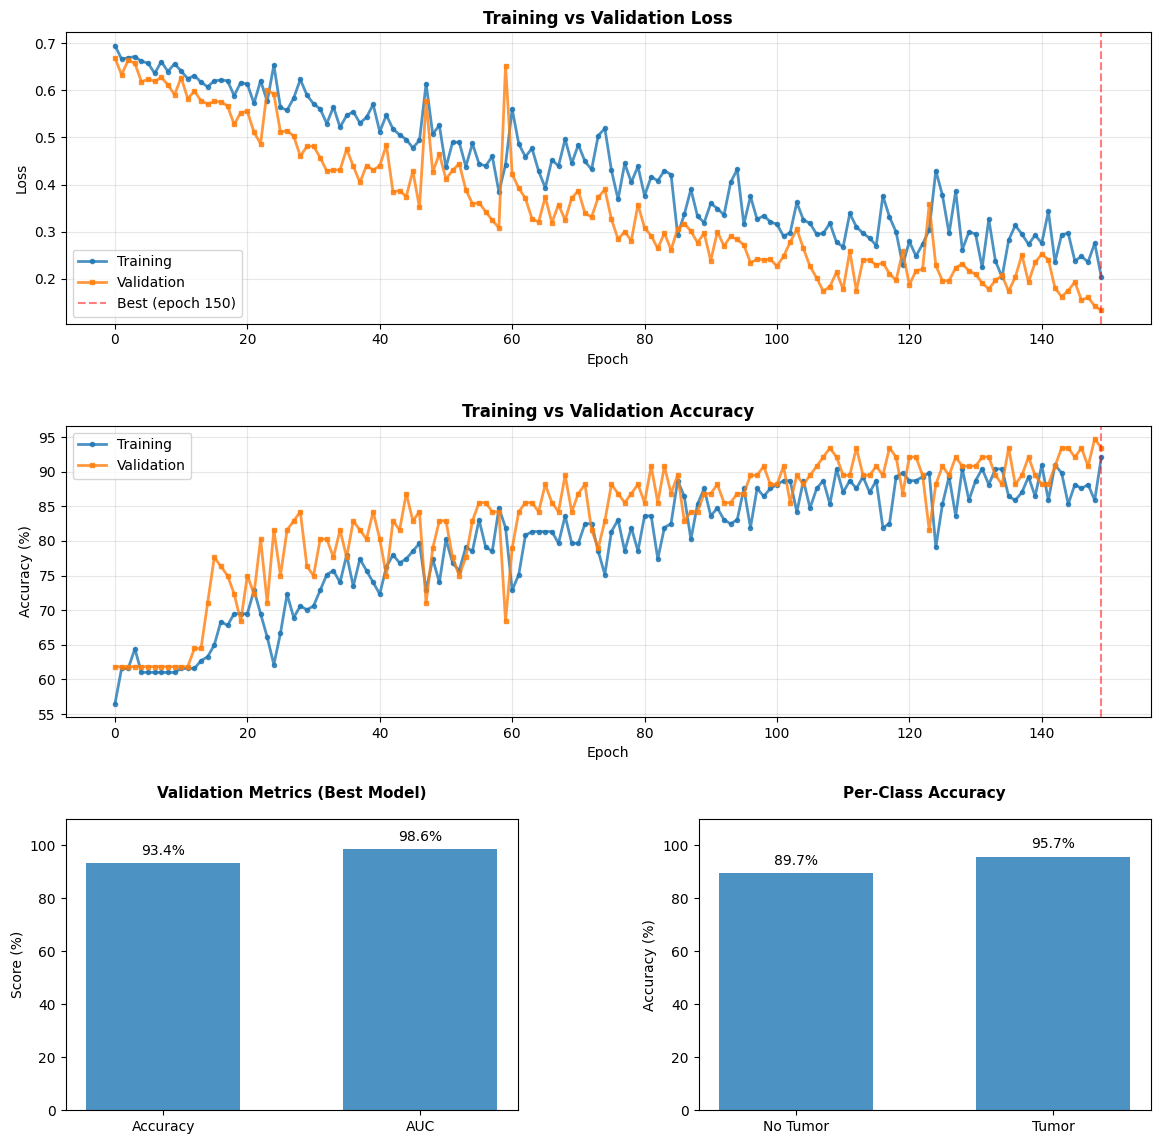


Final Results (Best Model from Epoch 150):
  Training accuracy: 92.09%
  Validation accuracy: 93.42%
  AUC score: 0.986

Performance Metrics:
  Total training time: 3.38 minutes
  Average epoch time: 1.35 seconds
  Evaluation time: 0.21 seconds
  Max CPU memory: 494.38 MB
  Max GPU memory: 305.85 MB

✅ Results saved to results_imperative.csv


In [7]:
# Visualize results with validation curves
fig = plt.figure(figsize=(14, 14))
gs = fig.add_gridspec(3, 2, height_ratios=[2, 2, 2], hspace=0.35, wspace=0.4)

# Training and validation loss (larger, top)
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(history['train_losses'], marker='o', linewidth=2, markersize=3, label='Training', alpha=0.8)
ax1.plot(history['val_losses'], marker='s', linewidth=2, markersize=3, label='Validation', alpha=0.8)
ax1.axvline(x=history['best_epoch'], color='red', linestyle='--', alpha=0.5, label=f"Best (epoch {history['best_epoch']+1})")
ax1.set_title('Training vs Validation Loss', fontsize=12, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Training and validation accuracy (larger, middle)
ax2 = fig.add_subplot(gs[1, :])
ax2.plot(history['train_accs'], marker='o', linewidth=2, markersize=3, label='Training', alpha=0.8)
ax2.plot(history['val_accs'], marker='s', linewidth=2, markersize=3, label='Validation', alpha=0.8)
ax2.axvline(x=history['best_epoch'], color='red', linestyle='--', alpha=0.5)
ax2.set_title('Training vs Validation Accuracy', fontsize=12, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Validation metrics (bottom left)
ax3 = fig.add_subplot(gs[2, 0])
metrics_names = ['Accuracy', 'AUC']
metrics_values = [val_acc, auc_score*100]
bars = ax3.bar(metrics_names, metrics_values, alpha=0.8, width=0.6)
ax3.set_title('Validation Metrics (Best Model)', fontsize=11, fontweight='bold', pad=15)
ax3.set_ylabel('Score (%)', fontsize=10)
ax3.set_ylim([0, 110])

for i, v in enumerate(metrics_values):
    ax3.text(i, v + 2, f'{v:.1f}%', ha='center', va='bottom', fontsize=10)

# Per-class accuracy (bottom right)
ax4 = fig.add_subplot(gs[2, 1])
class_accuracies = [100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(2)]
bars = ax4.bar(class_names, class_accuracies, alpha=0.8, width=0.6)
ax4.set_title('Per-Class Accuracy', fontsize=11, fontweight='bold', pad=15)
ax4.set_ylabel('Accuracy (%)', fontsize=10)
ax4.set_ylim([0, 110])

for i, v in enumerate(class_accuracies):
    ax4.text(i, v + 2, f'{v:.1f}%', ha='center', va='bottom', fontsize=10)

plt.show()

print(f"\n{'='*60}")
print(f"Final Results (Best Model from Epoch {history['best_epoch']+1}):")
print(f"{'='*60}")
print(f"  Training accuracy: {history['train_accs'][history['best_epoch']]:.2f}%")
print(f"  Validation accuracy: {history['val_accs'][history['best_epoch']]:.2f}%")
print(f"  AUC score: {auc_score:.3f}")
print(f"\nPerformance Metrics:")
print(f"  Total training time: {history['total_time']/60:.2f} minutes")
print(f"  Average epoch time: {history['avg_epoch_time']:.2f} seconds")
print(f"  Evaluation time: {eval_time:.2f} seconds")
print(f"  Max CPU memory: {history['max_cpu_memory']:.2f} MB")
print(f"  Max GPU memory: {history['max_gpu_memory']:.2f} MB")
print(f"{'='*60}")

# Save results to CSV
import csv
from datetime import datetime
from pathlib import Path

results_file = Path("results_imperative.csv")
file_exists = results_file.exists()

with open(results_file, 'a', newline='') as f:
    writer = csv.writer(f)
    
    # Write header if file is new
    if not file_exists:
        writer.writerow([
            'timestamp', 'notebook', 'best_epoch', 
            'train_accuracy', 'val_accuracy', 'auc_score',
            'train_loss', 'val_loss',
            'total_time_minutes', 'avg_epoch_time_seconds',
            'max_cpu_memory_mb', 'max_gpu_memory_mb', 'eval_time_seconds'
        ])
    
    # Write results
    writer.writerow([
        datetime.now().isoformat(),
        'imperative.ipynb',
        history['best_epoch'] + 1,
        history['train_accs'][history['best_epoch']],
        history['val_accs'][history['best_epoch']],
        auc_score,
        history['train_losses'][history['best_epoch']],
        history['val_losses'][history['best_epoch']],
        history['total_time'] / 60,
        history['avg_epoch_time'],
        history['max_cpu_memory'],
        history['max_gpu_memory'],
        eval_time
    ])

print(f"\n✅ Results saved to {results_file}")
